# Fused-Gromov Wasserstein Barycenter example

This notebook presents an usage example of FGW Barycenter solver. Let $G = (Y, C, p_s)$, in this example, we consider computing barycenter of $K=10$ graphs. Hence, the loaded variables below have $Y_k \in \mathbb{R}^{K \times N \times d}, C_k \in \mathbb{R}^{K \times N \times N}, p_s \in \mathbb{R}^{N}$, where $N$ is the number of nodes and $d$ is feature dimension. 

In [2]:
import torch
import sys
sys.path.append('..')
from conan_fgw.src.model.fgw.barycenter import fgw_barycenters, fgw_barycenters_BAPG
import time
import ot
from pathlib import Path

# file path
path = Path('.')
debug_dict = torch.load((path / 'data' / 'cfm_log.pt').as_posix())
N = debug_dict["N"]
Ys = debug_dict["Ys"]
Cs = debug_dict["Cs"]
ps = debug_dict["ps"]
lambdas = debug_dict["lambdas"]
Ys = torch.stack(Ys)
Cs = torch.stack(Cs)
ps = torch.stack(ps)
p = torch.ones(N) / N
p = p.to(Ys.device)

print(f'Feature shapes: {Ys.shape}')
print(f'Structure shapes: {Cs.shape}')
print(f'Source marginal shapes: {ps.shape}')
print(f'Target marginal shapes: {p.shape}')

Feature shapes: torch.Size([10, 22, 3])
Structure shapes: torch.Size([10, 22, 22])
Source marginal shapes: torch.Size([10, 22])
Target marginal shapes: torch.Size([22])


/tmp/ipykernel_496863/3641633013.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  debug_dict = torch.load((path / 'data' / 'cfm_log.pt').as_posix())


Now, we compare the performance and computational time vs. Conjugated gradient method

In [5]:
def mse(A, B):
    return torch.mean((A - B) ** 2).item()

start = time.time()
F_bary_ref, C_bary_ref, log = ot.gromov.fgw_barycenters(N=N, Ys=Ys, Cs=Cs, ps=ps, lambdas=lambdas, p=p, warmstartT=True, symmetric=True,
                                alpha=0.5, fixed_structure=False, fixed_features=False, loss_fun='kl_loss', max_iter=50, tol=1e-5,
                                verbose=False, log=True, init_C=None, init_X=None, random_state=None)
print("FGW CG Time elapsed: ", time.time() - start)

start = time.time()
F_bary1, C_bary1, log = fgw_barycenters(N=N, Ys=Ys, Cs=Cs, ps=ps, lambdas=lambdas, p=p, warmstartT=True, symmetric=False, method='sinkhorn_log',
                                alpha=0.5, solver='PGD', fixed_structure=False, fixed_features=False, epsilon=0.05, loss_fun='kl_loss', max_iter=50, tol=1e-5,
                                numItermax=50, stopThr=5e-2, verbose=False, log=True, init_C=None, init_X=None, random_state=None)
print("FGW Sinkhorn Time elapsed: ", time.time() - start)
print("FGW Sinkhorn Feature matrix difference: ", mse(F_bary1, F_bary_ref))
print("FGW Sinkhorn Structure matrix difference: ", mse(C_bary1, C_bary_ref))

FGW CG Time elapsed:  0.05827474594116211
FGW Sinkhorn Time elapsed:  5.201070785522461
FGW Sinkhorn Feature matrix difference:  0.27334436774253845
FGW Sinkhorn Structure matrix difference:  0.024793388321995735


The output $G_o = (Y_o, C_o, p)$ has the same tensor dimension as the components.

In [6]:
print(f'Feature shapes: {F_bary1.shape}')
print(f'Structure shapes: {C_bary1.shape}')

Feature shapes: torch.Size([22, 3])
Structure shapes: torch.Size([22, 22])


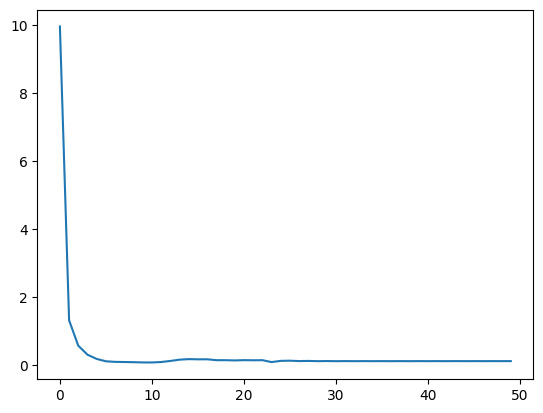

In [11]:
# plot err_feature and err_structure
import matplotlib.pyplot as plt
plt.plot(log['err_feature'], label='err_feature')
plt.show()

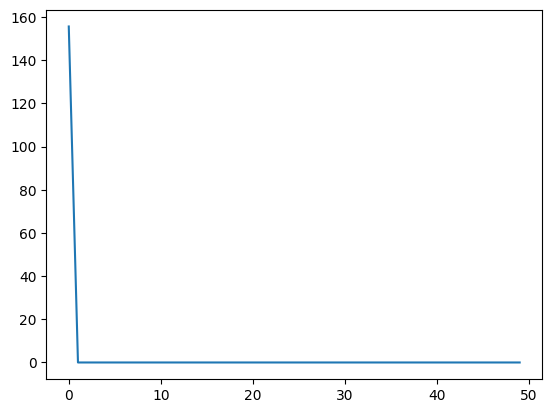

In [12]:
plt.plot(log['err_structure'], label='err_structure')
plt.show()